<h1><center>8.OBJECT DETECTION USING SIFT, GLOH, HOG AND IMAGE CLASSIFICATION</center></h1>

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import hog

<h1>1)Object Detection using SIFT</h1>

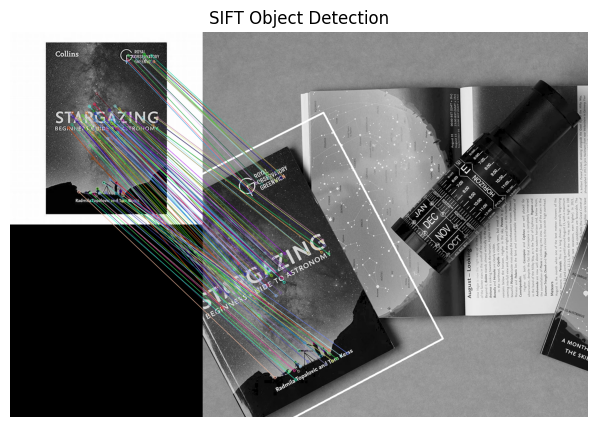

In [ ]:
# Load images
query_img = cv2.imread(r"book.jpg", cv2.IMREAD_GRAYSCALE)  #Replace with your image path
train_img = cv2.imread(r"books.png", cv2.IMREAD_GRAYSCALE) #Replace with your image path

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(query_img, None)
keypoints2, descriptors2 = sift.detectAndCompute(train_img, None)

# Use FLANN-based matcher for feature matching
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply Lowe's ratio test
good_matches = [m for m, n in matches if m.distance < 0.6 * n.distance]

# Find homography if enough matches are found
if len(good_matches) > 10:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

    # Get object corners
    h, w = query_img.shape
    pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    
    # Map object corners onto scene
    dst = cv2.perspectiveTransform(pts, matrix)
    train_img = cv2.polylines(train_img, [np.int32(dst)], True, (255, 0, 0), 3)

# Draw matches
inliers = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
matched_img = cv2.drawMatches(query_img, keypoints1, train_img, keypoints2, inliers, None, flags=2)

# Show image
plt.figure(figsize=(10, 5))
plt.imshow(matched_img)
plt.title("SIFT Object Detection")
plt.axis('off')
plt.show()

<h1>2)Object Detection using GLOH</h1>

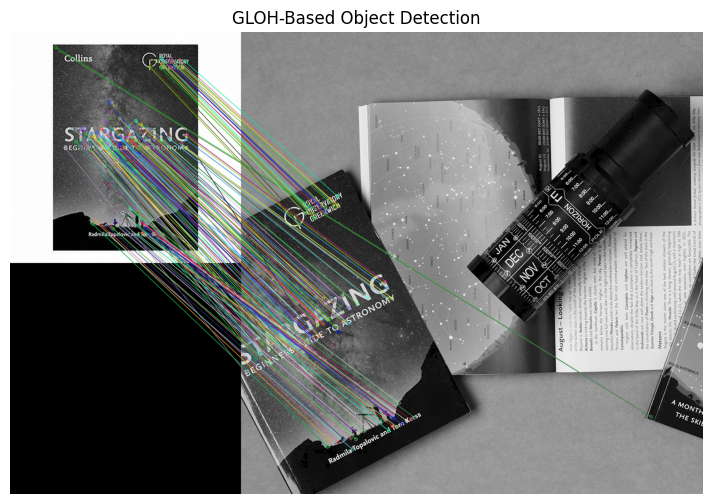

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load images
query_img = cv2.imread(r"book.jpg", cv2.IMREAD_GRAYSCALE)  #Replace with your image path # Object to detect
train_img = cv2.imread(r"books.png", cv2.IMREAD_GRAYSCALE)  #Replace with your image path # Scene image

# Initialize SIFT (since OpenCV does not have direct GLOH)
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(query_img, None)
kp2, des2 = sift.detectAndCompute(train_img, None)

# Convert descriptors to log-polar space (GLOH step)
def convert_to_log_polar(descriptors):
    modified_descriptors = []
    for desc in descriptors:
        # Convert to log-polar space (approximation)
        log_polar_desc = np.log(1 + desc)
        modified_descriptors.append(log_polar_desc)
    return np.array(modified_descriptors)

des1_gloh = convert_to_log_polar(des1)
des2_gloh = convert_to_log_polar(des2)

# Apply PCA to reduce from 272 to 128 dimensions
pca = PCA(n_components=128)
des1_pca = pca.fit_transform(des1_gloh)
des2_pca = pca.transform(des2_gloh)

# Match descriptors using FLANN
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1_pca, des2_pca, k=2)

# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw matches
matched_img = cv2.drawMatches(query_img, kp1, train_img, kp2, good_matches, None, flags=2)

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(matched_img)
plt.title("GLOH-Based Object Detection")
plt.axis("off")
plt.show()


<h1>Image Classification using GLOH</h1>

Classification Accuracy: 0.4527777777777778


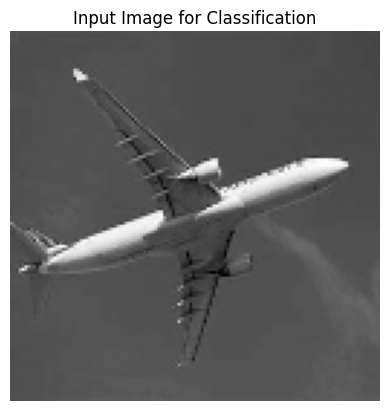

Predicted Category: planes


In [ ]:
# Define fixed feature length for consistency
FIXED_COMPONENTS = 64  

# Function to compute GLOH features (approximate using SIFT + PCA)
def compute_gloh_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None or len(descriptors) == 0:
        return np.zeros(FIXED_COMPONENTS)  # Return zero vector if no keypoints

    # Convert descriptors to log-polar space (approximate GLOH)
    log_polar_descriptors = np.log1p(descriptors)  

    # Apply PCA to reduce dimensionality
    n_samples, n_features = log_polar_descriptors.shape
    n_components = max(2, min(FIXED_COMPONENTS, n_samples, n_features))  

    pca = PCA(n_components=n_components)
    reduced_descriptors = pca.fit_transform(log_polar_descriptors)

    # Pad feature vector to FIXED_COMPONENTS if needed
    padded_features = np.zeros(FIXED_COMPONENTS)
    padded_features[:reduced_descriptors.shape[1]] = reduced_descriptors.mean(axis=0)

    return padded_features

# Load dataset
dataset_path = r"dataset"  # Update this path #Replace with your dataset path
categories = ["cars", "trains", "planes"]
X, y = [], []

for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))  # Resize for consistency
        features = compute_gloh_features(img)
        
        if features is not None:
            X.append(features)
            y.append(label)

X = np.array(X)
y = np.array(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply K-Means clustering (K=3 for 3 categories)
kmeans = KMeans(n_clusters=3, random_state=42)
X_train_kmeans = kmeans.fit_transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

# Train SVM classifier using K-Means transformed features
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_kmeans, y_train)

# Test accuracy
y_pred = svm_model.predict(X_test_kmeans)
accuracy = accuracy_score(y_test, y_pred)
print("Classification Accuracy:", accuracy)

# Function to classify a single input image
def classify_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Display image using Matplotlib
    plt.imshow(img, cmap='gray')
    plt.title("Input Image for Classification")
    plt.axis("off")
    plt.show()

    features = compute_gloh_features(img)

    if features is None:
        return "No keypoints detected"

    # Transform features using trained K-Means
    features_kmeans = kmeans.transform(features.reshape(1, -1))

    # Predict using SVM
    prediction = svm_model.predict(features_kmeans)

    return categories[prediction[0]]

# Test single image classification
test_image_path = r"plane.jpg"  #Replace with your test image path
predicted_label = classify_image(test_image_path)
print("Predicted Category:", predicted_label)
